**Advanced NLP Assignment <br>
Name: Rohan Tuli <br>
Candidate number: 245309**

In [64]:
import os, random, math, sys, time, csv, re, string, argparse, collections
import nltk
from nltk import word_tokenize as tokenize
from nltk import sent_tokenize
import numpy as np
import operator
import pandas as pd
import matplotlib.pyplot as plt 
nltk.download('punkt')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, normalize
from scipy import spatial
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
import warnings
warnings.filterwarnings("ignore")
import multiprocessing
import torch
from torch import nn

[nltk_data] Downloading package punkt to /Users/rt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
# defining paths

# parent and training path
PARENT_DIR = "/Users/rt/Sussex/Spring/Advanced NLP/Lab 2"
TRAINING_DIR = PARENT_DIR + "/Holmes_Training_Data"

# paths for sentence completion challenge questions and answers 
questions_file = PARENT_DIR + "/testing_data.csv"
answers_file = PARENT_DIR + "/test_answer.csv"

# path to store the data
results_directory = "/Users/rt/Desktop"
rt_path = "/Users/rt/Desktop/College/M.Sc/Semester 2/Advanced Natural Language Processing/Assignments/1"

# N - Gram model

## Dividing the data into training and testing

In [6]:
def get_training_testing(training_dir,split=0.5):
    """
        Function to divide the training and testing data
    :param training_dir: directory with the training files
    :param split: ratio of splitting the training and testing data
    :return: training files and testing files
        
    """
    filenames=os.listdir(training_dir)
    n=len(filenames)
    print("There are {} files in the training directory: {}".format(n,training_dir))
    
    # keeping the split constant throughout
    random.seed(53)  
    random.shuffle(filenames)
    index=int(n*split)
    
    # training files
    trainingfiles=filenames[:index]
    
    # testing files
    heldoutfiles=filenames[index:]
    return trainingfiles,heldoutfiles

## Language modelling class

In [12]:
# language modelling class. Implements the following n-grams:
# 1. Unigram
# 2. Bigram
# 3. Trigram

class language_model():
    def __init__(self, known=2, discount=0.75, trainingdir=TRAINING_DIR, files=[]):
        """
            Constructor method initialising the language model
        :param known: number of known variables
        :param discount: value to be removed from the distribution
        :param trainingdir: directory with the training files
        :param files: files to be used
        """
        self.training_dir = trainingdir
        self.files = files
        self.discount = discount
        self.known = known
        self.train()
      
    def train(self):
        """
            Function to train the respective Unigram, Bigram and Trigram models
        :return: None
        """
        
        # defining the Unigram, Bigram and Trigrams
        self.unigram = {}
        self.bigram = {}
        self.trigram = {}
        self.count_token = {}

        # calling function for processing the files and dealing with unknowns 
        self._processfiles()
        self._make_unknowns()
        self._kneser_ney()

        # converting unigram, bigram and trigram distributions to probabilities
        self._convert_to_probs()

    def _processline(self,line):
        """
            Function to process a single line
        :param line: line to br processed
        :return: None
        """
        
        # adding identifiers to the start and the end of the line
        tokens = ["__START"] + tokenize(line) + ["__END"]
        previous = "__END"
        tri_prev = ["__END", "__END"]
        for token in tokens:
            
            # inserting words into the unigram
            self.unigram[token] = self.unigram.get(token,0) + 1

            # counting tokens
            self.count_token[token] = self.count_token.get(token,0) + 1

            # inserting words into the bigram
            temp_bg = self.bigram.get(previous,{})
            temp_bg[token] = temp_bg.get(token,0) + 1
            self.bigram[previous] = temp_bg

            # inserting words into the trigram
            tri_prev[1], tri_prev[0] = tri_prev[0], tri_prev[1]
            tri_prev[1] = previous

            current_tri = self.trigram.get(tuple(tri_prev), {})
            current_tri[token] = current_tri.get(token, 0) + 1
            self.trigram[tuple(tri_prev)] = current_tri

            previous = token
    
    def _processfiles(self):
        """
            Function to process all files
        """
        for afile in self.files:
            try:
                
                # opening the directory
                with open(os.path.join(self.training_dir,afile)) as instream:
                    for line in instream:
                        line = line.rstrip()
                        if len(line) > 0:
                            
                            # processing a single line
                            self._processline(line)
            except UnicodeDecodeError:
                
                # ignoring the file if UnicodeDecodeError
                print("UnicodeDecodeError processing {}: ignoring rest of file".format(afile))
  
          
    def _convert_to_probs(self):
        """
            Function to convert distribution to probabilities.
            Converting unigram, bigram and trigram distributions to probabilities
            and creates the knesser-ney discounted distributions for bigrams and
            trigrams.
        """
        self.unigram = {k:v/sum(self.unigram.values()) for (k,v) in self.unigram.items()}
        self.bigram = {key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.bigram.items()}
        self.trigram = {key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.trigram.items()}
        self.kn = {k:v/sum(self.kn.values()) for (k,v) in self.kn.items()}
        self.kn_tri = {k:v/sum(self.kn_tri.values()) for (k,v) in self.kn_tri.items()}
    
    
    def get_prob(self,token,context="",methodparams={}):
        """
            Function to obtain the probability of n-gram model
        :param token: token to be processed
        :param context: context with respect to the token
        :param methodparams: dictionary containing the type of n-gram model 
                             and smoothing method
        :return p: probability for the respective token
        """
        
        # unigram method
        if methodparams.get("method","unigram") == "unigram":
            return self.unigram.get(token,self.unigram.get("__UNK",0))
        
        # bigram method
        elif methodparams.get("method","bigram") == "bigram":
            
            # check for kneser ney smoothing
            if methodparams.get("smoothing","kneser-ney") == "kneser-ney":
                unidist = self.kn
            else:
                unidist = self.unigram

            # discounting
            bigram = self.bigram.get(context[-1],self.bigram.get("__UNK",{}))
            big_p = bigram.get(token,bigram.get("__UNK",0))
            lmbda = bigram["__DISCOUNT"]
            uni_p = unidist.get(token,unidist.get("__UNK",0))
            p = big_p + lmbda * uni_p            
            return p
        
        # trigram method
        elif methodparams.get("method","trigram") == "trigram":
            
            # check for kneser ney smoothing
            if methodparams.get("smoothing","kneser-ney") == "kneser-ney":
                unidist = self.kn_tri
                unidist_bi = self.kn
            else:
                unidist_bi = self.unigram

            # to check if context is within the range
            if len(context) < 2:
                context = ["__END", context[0]]
                
            # storing trigrams as a tuple inside a dictionary
            trigram = self.trigram.get(tuple(context[-2:]),self.trigram.get("__UNK",{}))
            trigram_prob = trigram.get(token, trigram.get("__UNK",0))
            
            # storing the trigram discount
            lambda_trigram = trigram["__DISCOUNT"]
            
            # determining the context from the bigram
            bigram = self.bigram.get(context[-1], self.bigram.get("__UNK",{}))
            
            # bigram probability for the unknown word
            bigram_prob = bigram.get(token, bigram.get("__UNK",0))
            
            # discount for the bigram
            lambda_bigram = bigram["__DISCOUNT"]
            
            # probability of the unknown word
            unigram_prob = unidist_bi.get(token, unidist_bi.get("__UNK",0))
            
            # overall probability
            p = trigram_prob + (lambda_trigram * bigram_prob) + (lambda_bigram * unigram_prob)      
            return p
    
    def compute_prob_line(self,line,methodparams={}):
        """
            Function to compute the probability of a single line
        :param line: line to be processed
        :param methodparams: smooething and n - gram method
        :return: overall probabilty for the line and length of the tokens
        """
        # assign keywords to the start and end of the sentence
        tokens = ["__START"] + tokenize(line) + ["__END"]
        acc = 0
        
        # determing the probability of the line
        for i,token in enumerate(tokens[1:]):
            acc += math.log(self.get_prob(token,tokens[:i+1],methodparams))
        return acc,len(tokens[1:])
    
    def compute_probability(self,filenames=[],methodparams={}):
        """
            Function to compute the probability of the data
        :param filenames: list of file name
        :param methodparams: type of model and respective params
        :return: overall probability and number of lines
        
        """
        
        # check for empty files
        if filenames == []:
            filenames = self.files

        total_p = 0
        total_N = 0
        
        # use the file names to open and read the files
        for i,afile in enumerate(filenames):
            try:
                with open(os.path.join(self.training_dir,afile)) as instream:
                    for line in instream:
                        line = line.rstrip()
                        
                        # compute the probability of the line
                        if len(line) > 0:
                            p,N = self.compute_prob_line(line,methodparams=methodparams)
                            total_p += p
                            total_N += N
            
            # ignore file if error
            except UnicodeDecodeError:
                print("UnicodeDecodeError processing file {}: ignoring rest of file".format(afile))
        return total_p,total_N
    
    def compute_perplexity(self,filenames=[],methodparams={"method":"bigram","smoothing":"kneser-ney"}):
        """
            Function to calculate perplexity of the model
        :param filenames: names of the files
        :param methodparams: type of model and respective params
        :return: perplexity of the model
        
        """
        p, N = self.compute_probability(filenames=filenames,methodparams=methodparams)
        pp = math.exp(-p/N)
        return pp  

    def _make_unknowns(self):
        """
            Function to deal with unknown words
        :return: None
        """
        
        # reducing and assigning a small value from the unigram towards the unknown token
        unknown = 0
        self.number_unknowns = 0
        for (k,v) in list(self.unigram.items()):
            if v < self.known:
                del self.unigram[k]
                self.unigram["__UNK"] = self.unigram.get("__UNK",0) + v
                self.number_unknowns += 1

        # reducing and assigning a small value from the bigram towards the unknown token
        for (k,adict) in list(self.bigram.items()):
            for (kk,v) in list(adict.items()):
                isknown = self.unigram.get(kk,0)
                if isknown == 0 and not kk == "__DISCOUNT":
                    adict["__UNK"] = adict.get("__UNK",0) + v
                    del adict[kk]
            isknown = self.unigram.get(k,0)
            if isknown == 0:
                del self.bigram[k]
                current = self.bigram.get("__UNK",{})
                current.update(adict)
                self.bigram["__UNK"] = current
            else:
                self.bigram[k] = adict

        # reducing and assigning a small value from the Trigram towards the unknown token
        for (k,adict) in list(self.trigram.items()):
            for (kk,v) in list(adict.items()):
                isknown = self.unigram.get(kk,0)
                if isknown == 0 and not kk == "__DISCOUNT":
                    adict["__UNK"] = adict.get("__UNK",0) + v
                    del adict[kk]
            prev_1, prev_2 = k
            isknown_1, isknown_2 = self.unigram.get(prev_1,0), self.unigram.get(prev_2,0)
            if isknown_1 == 0 or isknown_2 == 0:
                del self.trigram[k]
                current = self.trigram.get("__UNK",{})
                current.update(adict)
                self.trigram["__UNK"] = current
            else:
                self.trigram[k] = adict
        
              
    def _kneser_ney(self):
        """
            Function to convert use Kneser Ney smoothing
        :return: None
        """
        # discounting each individual bigram by 0.75
        self.bigram = {k:{kk:value-self.discount for (kk,value) in adict.items()} for (k,adict) in self.bigram.items()}

        # discounting each individual trigram by 0.75
        self.trigram = {k:{kk:value-self.discount for (kk,value) in adict.items()} for (k,adict) in self.trigram.items()}

        # For each word, store the total amount of the discount so that the total is the same 
        # i.e., so we are reserving this as probability mass
        for k in self.bigram.keys():
            lamb = len(self.bigram[k])
            self.bigram[k]["__DISCOUNT"] = lamb * self.discount
        
        for k in self.trigram.keys():
            lamb = len(self.trigram[k])
            self.trigram[k]["__DISCOUNT"] = lamb * self.discount

        # Work out kneser-ney unigram probabilities
        # Count the number of contexts each word has been seen in
        self.kn = {}
        for (k,adict) in self.bigram.items():
            for kk in adict.keys():
                self.kn[kk] = self.kn.get(kk,0) + 1

        self.kn_tri = {}
        for (k,adict) in self.trigram.items():
            for kk in adict.keys():
                self.kn_tri[kk] = self.kn_tri.get(kk,0) + 1

## Question creation class

In [13]:
# class to predict and score from the data read 
# from the sentence completion challenge

class question:
    def __init__(self,aline):
        """
            Initialisation function
        :param aline: line to be processed
        """
        self.fields=aline
  
    def get_field(self, field):
        """
            Function to get the respective field
        :param field: column to be used
        """
        return self.fields[question.colnames[field]]
  
    def add_answer(self,fields):
        """
            Function to add the answer
        :param fields: row vector with the words
        """
        self.answer=fields[1]

    def get_tokens(self):
        """
            Function to tokenize the question.
            Adds keywords at the start and end 
            of the line
        """
        return ["__START"]+tokenize(self.fields[question.colnames["question"]])+["__END"]

    def get_left_context(self,window=1,target="_____"):
        """
            Function to determine the words on the 
            left of the given word.
            :param window: number of words to the left
            :param target: sequence to look for
        """
        found = -1
        sent_tokens = self.get_tokens()
        for i,token in enumerate(sent_tokens):
            if token == target:
                found = i
                break
        if found >- 1:
            # returning tokens around the defined window length
            return sent_tokens[i-window:i]
        else:
            return []

    def get_right_context(self,window=1,target="_____"):
        """
            Function to determine the words on the 
            right of the given word.
            :param window: number of words to the left
            :param target: sequence to look for
        """
        found = -1
        sent_tokens = self.get_tokens()
        for i,token in enumerate(sent_tokens):
            if token == target:
                found = i
                break  
        if found >- 1:
            # returning tokens around the defined window length
            return sent_tokens[found + 1:found + window + 1]
        
        else:
            return []

    def choose(self, lm, method="bigram",smoothing="Kneser-ney", choices=[]):
        """
            Function to choose the option from the given word using the model
        :param lm: langauge model (n-gram)
        :param method: unigram, bigram and trigram
        :param smoothing: method of smoothing
        :param choices: choice of words
        """
        if choices == []:
            choices = ["a", "b", "c", "d", "e"]

        # probability of the words given the context for a bigram
        if method == "bigram":
            rc = self.get_right_context(window=1)
            lc = self.get_left_context(window=1)
            probs = [lm.get_prob(rc[0],[self.get_field(ch+")")],methodparams={"method":method.split("_")[0], "smoothing":smoothing}) * lm.get_prob(self.get_field(ch+")"),lc,methodparams={"method":method.split("_")[0], "smoothing":smoothing}) for ch in choices]

        # probability of the words given the context for a trigram
        elif method == "trigram":
            rc = self.get_right_context(window=2)
            lc = self.get_left_context(window=2)
            probs = [lm.get_prob(self.get_field(ch+")"), lc, methodparams={"method":method.split("_")[0], "smoothing":smoothing})
                     * lm.get_prob(rc[0], [lc[-1]] + [self.get_field(ch+")")],methodparams={"method":method.split("_")[0], "smoothing":smoothing})
                     * lm.get_prob(rc[1], [self.get_field(ch+")")] + [rc[0]],methodparams={"method":method.split("_")[0], "smoothing":smoothing}) for ch in choices]
    
        else:
            context = self.get_left_context(window=1)
            probs = [lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":method.split("_")[0]}) for ch in choices]
    
        # most likely word
        maxprob = max(probs)
        bestchoices = [ch for ch,prob in zip(choices,probs) if prob == maxprob]

        return np.random.choice(bestchoices), probs
    
    def predict(self,lm,method="bigram", smoothing="kneser-ney"):
        """
            Function used for prediction using kneser-ney the answer.
        :param lm: language model
        :param method: unigram, bigram or trigram
        :param smoothing: method of smoothing
        :return: best choice obtained from the choose function
        """
        return self.choose(lm,method=method,smoothing=smoothing,choices=[])

    def predict_and_score(self,lm,method="bigram", smoothing="kneser-ney"):
        """
            Function used to predict the word and return the score. 
            1 for correct answer, 0 for incorrect.
        :param lm: language model
        :param method: unigram, bigram or trigram
        :param smoothing: method of smoothing
        :return: 1, prediction, probs if correct else, 0, prediction, probs
        """
        prediction, probs = self.predict(lm,method=method,smoothing=smoothing)

        if prediction == self.answer:
            return 1, prediction, probs
        else:
            return 0, prediction, probs

## Sentence completion challenge class

In [14]:
# class used for reading the sentence completion challenge data
class scc_reader:
    def __init__(self,qs,ans):
        """
            Initialisation function
        :param qs: question
        :param ans: answer
        """
        self.qs=qs
        self.ans=ans
        self.read_files()
    
    def read_files(self):
        """
            Function to read the files
        :return: None
        """
        #read in the question file
        with open(self.qs) as instream:
            csvreader=csv.reader(instream)
            qlines=list(csvreader)
    
        #store the column names as a reverse index so they can be used to reference parts of the question
        question.colnames={item:i for i,item in enumerate(qlines[0])}
    
        #create a question instance for each line of the file (other than heading line)
        self.questions=[question(qline) for qline in qlines[1:]]
    
        #read in the answer file
        with open(self.ans) as instream:
            csvreader=csv.reader(instream)
            alines=list(csvreader)
        
        #add answers to questions so predictions can be checked    
        for q,aline in zip(self.questions,alines[1:]):
            q.add_answer(aline)
      
    def get_field(self,field):
        """
            Function to get the field from the respective line
        :param field: index of field
        :params fields: fields
        """
        return [q.get_field(field) for q in self.questions] 
  
    def predict(self,method="bigram"):
        """
            Function to predict for a given question
        :param method: language model
        :return: predictions
        """
        return [q.predict(method=method) for q in self.questions]
  
    def predict_and_score(self,lm,method="bigram",smoothing="kneser-ney"):
        """
            Function for prediction and scoring 
        :param lm: language model
        :param method: unigram, bigram or trigram
        :param smoothing: method of smoothing
        :return: accuracy, prediction and probability distribution
        """
        predictions = []
        scores = []
        total_probs = []
        for q in self.questions:
            score, pred, probs = q.predict_and_score(lm,method=method, smoothing=smoothing)
            scores.append(score)
            predictions.append(pred)
            total_probs.append(probs)
        return sum(scores)/len(scores), predictions, total_probs

In [16]:
# testing the n-gram model for different hyper parameters
# 1. Number of files
# 2. Known words

fls = os.listdir(TRAINING_DIR)

# defining the usage of number of files
number_files = [10, 20, 30, 40, 50]

# out of vocabulary threshold
known = [2, 3, 4]

# other parameters
discount = 0.75
smoothing = 'kneser-ney'
MAX_FILES = 2
results = []
predictions = []
total_probs = []
count = 0
for n in number_files:
    for k in known:
        print('Processing {} documents...'.format(n))
        mylm = language_model(known=k, discount=discount, files=fls[:n])
        SCC = scc_reader(questions_file, answers_file)

        unigram_accuracy, unigram_predictions, unigram_probs = SCC.predict_and_score(mylm,method="unigram",smoothing=smoothing)
        bigram_accuracy, bigram_predictions, bigram_probs = SCC.predict_and_score(mylm,method="bigram",smoothing=smoothing)
        trigram_accuracy, trigram_predictions, trigram_probs = SCC.predict_and_score(mylm,method="trigram",smoothing=smoothing)

        results.append((n, k, unigram_accuracy, bigram_accuracy, trigram_accuracy))
        predictions.append((unigram_predictions, bigram_predictions, trigram_predictions))
        total_probs.append((unigram_probs, bigram_probs, trigram_probs))

    count += 1

Processing 10 documents...
Processing 10 documents...
Processing 10 documents...
Processing 20 documents...
Processing 20 documents...
Processing 20 documents...
Processing 30 documents...
Processing 30 documents...
Processing 30 documents...
Processing 40 documents...
Processing 40 documents...
Processing 40 documents...
Processing 50 documents...
Processing 50 documents...
Processing 50 documents...


In [17]:
cols = ['number of files', 'OOV threshold', 'unigram accuracy', 'bigram accuracy', 'trigram accuracy']
values = results
df_ngram = pd.DataFrame(values, columns=cols)
display(df_ngram)

,number of files,OOV threshold,unigram accuracy,bigram accuracy,trigram accuracy
0,10,2,0.172115,0.187500,0.236538
1,10,3,0.164423,0.194231,0.230769
2,10,4,0.164423,0.196154,0.233654
3,20,2,0.206731,0.191346,0.215385
4,20,3,0.200000,0.179808,0.219231
5,20,4,0.184615,0.173077,0.215385
6,30,2,0.232692,0.207692,0.239423
7,30,3,0.225962,0.206731,0.232692
8,30,4,0.228846,0.192308,0.225000
9,40,2,0.251923,0.191346,0.224038


## Analysis of the n-gram models

In [22]:
# storing the data in dictionaries

oov_threshold = [2, 3, 4]
n_files = [10, 20, 30, 40, 50]
u = {}
b = {}
t = {}
for thresh in oov_threshold:
    u[thresh], b[thresh], t[thresh] = {}, {}, {}
    res = df_ngram.loc[df_ngram["OOV threshold"] == thresh]
    for n in n_files:
        res1 = res.loc[res["number of files"] == n]
        u[thresh][n] = res1["unigram accuracy"].values.tolist()[0]
        b[thresh][n] = res1["bigram accuracy"].values.tolist()[0]
        t[thresh][n] = res1["trigram accuracy"].values.tolist()[0]

In [23]:
def plot_oov_thresh(data, method):
    """
        Function to plot the out of vocab threshold
        vs the number of files of n-grams
    :param data: dictionary with respective metrics
    :param method: type of n-gram
    """
    for i in oov_threshold:
        plt.plot(data[i].keys(), data[i].values(), label = f"{method} with oov = {i}")
        plt.xlabel("Number of files")
        plt.ylabel("Accuracy (%)")
        plt.legend()
        plt.title(f"{method} accuracy vs number of files for different OOV")
    plt.savefig(f"{rt_path}/{method}.png")
    plt.show()

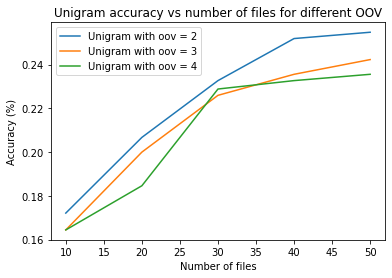

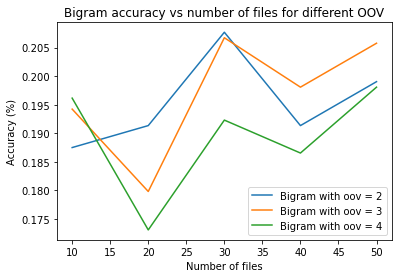

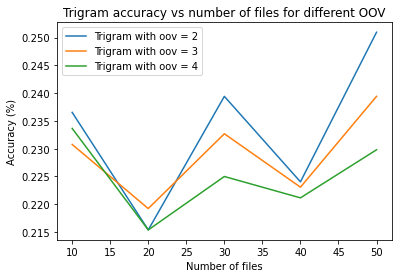

In [24]:
plot_oov_thresh(u, "Unigram")
plot_oov_thresh(b, "Bigram")
plot_oov_thresh(t, "Trigram")

[]

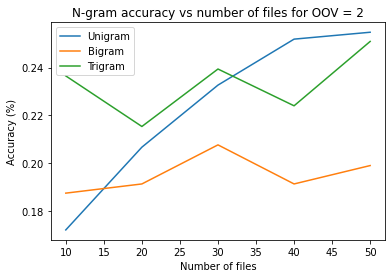

In [25]:
plt.plot(u[2].keys(), u[2].values(), label = f"Unigram")
plt.plot(b[2].keys(), b[2].values(), label = f"Bigram")
plt.plot(t[2].keys(), t[2].values(), label = f"Trigram")
plt.xlabel("Number of files")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title(f"N-gram accuracy vs number of files for OOV = 2")
plt.savefig(f"{rt_path}/all_gram.png")
plt.plot()

<AxesSubplot:xlabel='number of files'>

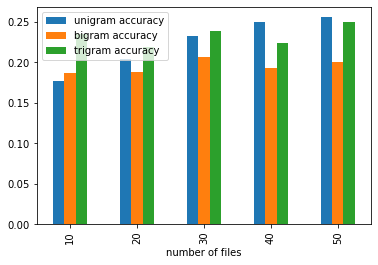

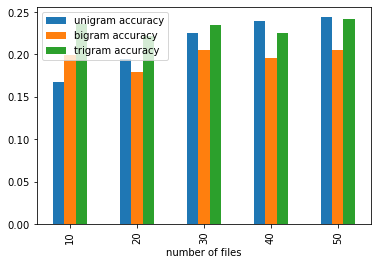

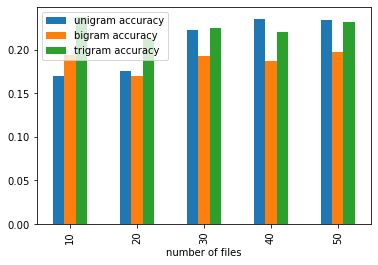

In [38]:
df_ngram_1 = df.loc[df["OOV threshold"] == 2]
df_ngram_2 = df.loc[df["OOV threshold"] == 3]
df_ngram_3 = df.loc[df["OOV threshold"] == 4]

df_ngram_1.plot.bar(x="number of files", y = ["unigram accuracy", "bigram accuracy", "trigram accuracy"])
df_ngram_2.plot.bar(x="number of files", y = ["unigram accuracy", "bigram accuracy", "trigram accuracy"])
df_ngram_3.plot.bar(x="number of files", y = ["unigram accuracy", "bigram accuracy", "trigram accuracy"])

In [31]:
# using the best parameters based on the previous analysis
known = 2
discount = 0.75
smoothing = 'kneser-ney'

mylm = language_model(known=known, discount=discount, files=fls)
SCC = scc_reader(questions_file, answers_file)

unigram_accuracy, unigram_predictions, unigram_probs = SCC.predict_and_score(mylm,method="unigram",smoothing=smoothing)
bigram_accuracy, bigram_predictions, bigram_probs = SCC.predict_and_score(mylm,method="bigram",smoothing=smoothing)
trigram_accuracy, trigram_predictions, trigram_probs = SCC.predict_and_score(mylm,method="trigram",smoothing=smoothing)

DF = pd.DataFrame(list(zip([str(i) for i in range(len(unigram_predictions))], 
                           unigram_predictions, unigram_probs, bigram_predictions, 
                           bigram_probs, trigram_predictions, trigram_probs)), 
                  columns =['id', 'answer unigram', 'probs unigram', 'answer bigram', 
                            'probs bigram', 'answer trigram', 'probs trigram'])

UnicodeDecodeError processing MOHIC10.TXT: ignoring rest of file
UnicodeDecodeError processing GHROS10.TXT: ignoring rest of file
UnicodeDecodeError processing LLIFE10.TXT: ignoring rest of file
UnicodeDecodeError processing ACHOE10.TXT: ignoring rest of file
UnicodeDecodeError processing TNGLW10.TXT: ignoring rest of file
UnicodeDecodeError processing MFRND10.TXT: ignoring rest of file
UnicodeDecodeError processing WTSLW10.TXT: ignoring rest of file
UnicodeDecodeError processing HHOHG10.TXT: ignoring rest of file
UnicodeDecodeError processing HFDTR10.TXT: ignoring rest of file
UnicodeDecodeError processing PHIL410.TXT: ignoring rest of file
UnicodeDecodeError processing DTROY10.TXT: ignoring rest of file
UnicodeDecodeError processing KRSON10.TXT: ignoring rest of file
UnicodeDecodeError processing TBTAS10.TXT: ignoring rest of file


In [32]:
print(f"For {len(fls)} files:\nUnigram accuracy : {unigram_accuracy}\nBigram accuracy : {bigram_accuracy}\nTrigram accuracy : {trigram_accuracy}")

For 522 files:
Unigram accuracy : 0.25096153846153846
Bigram accuracy : 0.2586538461538462
Trigram accuracy : 0.3230769230769231


In [34]:
mylm.compute_perplexity(filenames=[],methodparams={"method":"unigram", "smoothing":"kneser-ney"})

UnicodeDecodeError processing file MOHIC10.TXT: ignoring rest of file
UnicodeDecodeError processing file GHROS10.TXT: ignoring rest of file
UnicodeDecodeError processing file LLIFE10.TXT: ignoring rest of file
UnicodeDecodeError processing file ACHOE10.TXT: ignoring rest of file
UnicodeDecodeError processing file TNGLW10.TXT: ignoring rest of file
UnicodeDecodeError processing file MFRND10.TXT: ignoring rest of file
UnicodeDecodeError processing file WTSLW10.TXT: ignoring rest of file
UnicodeDecodeError processing file HHOHG10.TXT: ignoring rest of file
UnicodeDecodeError processing file HFDTR10.TXT: ignoring rest of file
UnicodeDecodeError processing file PHIL410.TXT: ignoring rest of file
UnicodeDecodeError processing file DTROY10.TXT: ignoring rest of file
UnicodeDecodeError processing file KRSON10.TXT: ignoring rest of file
UnicodeDecodeError processing file TBTAS10.TXT: ignoring rest of file


732.4829603719378

In [36]:
mylm.compute_perplexity(filenames=[],methodparams={"method":"bigram", "smoothing":"kneser-ney"})

UnicodeDecodeError processing file MOHIC10.TXT: ignoring rest of file
UnicodeDecodeError processing file GHROS10.TXT: ignoring rest of file
UnicodeDecodeError processing file LLIFE10.TXT: ignoring rest of file
UnicodeDecodeError processing file ACHOE10.TXT: ignoring rest of file
UnicodeDecodeError processing file TNGLW10.TXT: ignoring rest of file
UnicodeDecodeError processing file MFRND10.TXT: ignoring rest of file
UnicodeDecodeError processing file WTSLW10.TXT: ignoring rest of file
UnicodeDecodeError processing file HHOHG10.TXT: ignoring rest of file
UnicodeDecodeError processing file HFDTR10.TXT: ignoring rest of file
UnicodeDecodeError processing file PHIL410.TXT: ignoring rest of file
UnicodeDecodeError processing file DTROY10.TXT: ignoring rest of file
UnicodeDecodeError processing file KRSON10.TXT: ignoring rest of file
UnicodeDecodeError processing file TBTAS10.TXT: ignoring rest of file


139.51763783768456

In [37]:
mylm.compute_perplexity(filenames=[],methodparams={"method":"trigram", "smoothing":"kneser-ney"})

UnicodeDecodeError processing file MOHIC10.TXT: ignoring rest of file
UnicodeDecodeError processing file GHROS10.TXT: ignoring rest of file
UnicodeDecodeError processing file LLIFE10.TXT: ignoring rest of file
UnicodeDecodeError processing file ACHOE10.TXT: ignoring rest of file
UnicodeDecodeError processing file TNGLW10.TXT: ignoring rest of file
UnicodeDecodeError processing file MFRND10.TXT: ignoring rest of file
UnicodeDecodeError processing file WTSLW10.TXT: ignoring rest of file
UnicodeDecodeError processing file HHOHG10.TXT: ignoring rest of file
UnicodeDecodeError processing file HFDTR10.TXT: ignoring rest of file
UnicodeDecodeError processing file PHIL410.TXT: ignoring rest of file
UnicodeDecodeError processing file DTROY10.TXT: ignoring rest of file
UnicodeDecodeError processing file KRSON10.TXT: ignoring rest of file
UnicodeDecodeError processing file TBTAS10.TXT: ignoring rest of file


46.89572837041436

# Distributional similarity measure

In [39]:
# loading the models
fasttext = api.load('fasttext-wiki-news-subwords-300');
filename = "/Users/rt/Downloads/GoogleNews-vectors-negative300.bin"
google_news = KeyedVectors.load_word2vec_format(filename, binary=True)
fasttext.init_sims(replace=True)

/Users/rt/opt/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  """


In [47]:
def get_embeddings(tokens, google_embeddings, fasttext_embeddings, google=True, fasttext=False):
    """
        Function to get the get the word embeddings
    :param tokens: list of tokens
    :param google_embeddings: google word embedding
    :param fasttext: fasttext word embeddings
    :param google: usage of the google embeddings
    :param fasttext: usage of the fasttext embeddings
    :return: word2vec matrix
    """
    d = google_embeddings['woman'].size
    word2vec = []
    for word in tokens:
        
        # check if google embeddings on
        if google and word in google_embeddings:
            word2vec.append(google_embeddings[word])
            
        # check if fasttext embeddings on
        elif fasttext and word in fasttext_embeddings:
            word2vec.append(fasttext_embeddings[word])
        
        # check if none of the words match
        else:
            
            # return a random value
            word2vec.append(np.random.uniform(-1,1,d))
    return word2vec

def total_similarity(v, q):
    """
        Function to compute the total similarity using cosine
    :param v: word2vec
    :param q: question vector
    :return score: finally score generated
    """  
    score = 0
    for vector in q:
        
        # calculate the cosine similarity
        cos_sim = spatial.distance.cosine(v, vector)
        score += 1- cos_sim
    return score

def total_similarity_average(candidate, vectors):
    """
        Function to calculate the average of the total similarity
    :param candidate: vector under consideration
    :param vectors: word2vec
    
    """
    s = 0
    for v in vectors:
        s += v
    
    # calculating the average embeddings
    avg = s / len(vectors)
    
    # calculating the cosine distance
    score = 1 - spatial.distance.cosine(avg, candidate)

    return score

In [48]:
def word2vec_predictions(e1, e2, google, fasttext, avg_sim=False):
    """
        Function to create the word2vec predictions
    :param e1: True or False
    :param e2: True or False
    :param google: google embeddings
    :param fasttext: fasttext embeddings
    :param avg_sim: whether to use the average similarity
    :return: predictions, average score and overall scores
    """
    
    total_scores = []
    
    # loading the answers
    with open(answers_file) as instream:
        csvreader = csv.reader(instream)
        lines = list(csvreader)

    # storing the answers in the dataframe
    qs_df = pd.DataFrame(lines[1:],columns=lines[0])
    answers = np.array(qs_df['answer'])

    # defining the keys and the choices
    keys = ['a)', 'b)', 'c)', 'd)', 'e)']
    choices = ['a', 'b', 'c', 'd', 'e']
    predictions = []

    # opening the question files and storing it in the dataframe
    with open(questions_file) as qf:
        csvreader = csv.reader(qf)
        lines = list(csvreader)

    qs_df = pd.DataFrame(lines[1:],columns=lines[0])
    questions = list(qs_df['question'])

    # iterating the questions
    for i, question in enumerate(questions):
        
        # tokenizing the question
        tokens = tokenize(question)
        
        # obtaining the word embeddings
        ques_vec = get_embeddings(tokens, e1, e2, google, fasttext)
        scores = []
        candidates = [qs_df[x][i] for x in keys]

        # getting the candidate word embeddings
        cand_vec = get_embeddings(candidates, e1, e2, google, fasttext)

        # calculating the total word similarity
        for word in cand_vec:
            if not avg_sim:
                s = total_similarity(word, ques_vec)
            else:
                s = total_similarity_average(word, ques_vec)
            scores.append(s)
        idx = scores.index(max(scores))
        ans = choices[idx]
        predictions.append(ans)

        total_scores.append(scores)

        accuracy = np.sum(predictions == np.array(answers)) / len(predictions) * 100
    return np.array(predictions), accuracy, total_scores

In [58]:
# code to generate the results from the respective embeddings

results = []
pred_scores = []
google = [False, True]
holmes = [False, True]
avt = [False, True]
word2vec_scores = []
for g in google:
    for h in holmes:
        if not g and not h:
            continue
        for sim in avt:
            print('Google', g, 'Holmes', h, 'Sim', sim)
            predictions, accuracy, scores = word2vec_predictions(google_news, 
                                                                 fasttext, 
                                                                 g, h, sim)
            results.append((g, h, sim, accuracy))
            pred_scores.append((predictions, scores))

Google False Holmes True Sim False
Google False Holmes True Sim True
Google True Holmes False Sim False
Google True Holmes False Sim True
Google True Holmes True Sim False
Google True Holmes True Sim True


In [59]:
# storting in a dataframe

cols = ['Google embeddings', 'Fast text embeddings', 'Average total similarity', 'Word2Vec accuracy']
values = results
df_emb = pd.DataFrame(values, columns=cols)
display(df_emb)

,Google embeddings,Fast text embeddings,Average total similarity,Word2Vec accuracy
0,False,True,False,33.942308
1,False,True,True,31.634615
2,True,False,False,34.519231
3,True,False,True,31.923077
4,True,True,False,34.038462
5,True,True,True,37.115385


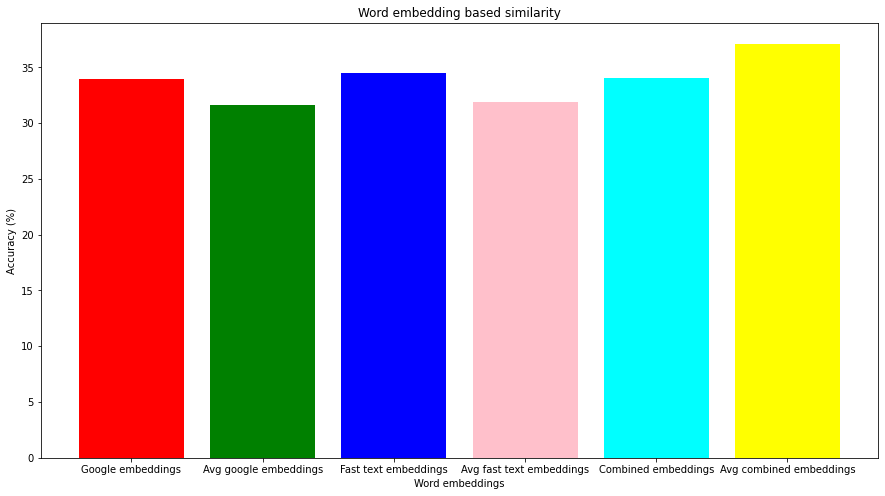

In [60]:
# plotting accuracies of the different methods

fig, ax = plt.subplots(figsize = (15, 8))
wv_acc = df_emb["Word2Vec accuracy"]
wv_techniques = ["Google embeddings", "Avg google embeddings", "Fast text embeddings", "Avg fast text embeddings", "Combined embeddings", "Avg combined embeddings"]
ax.bar(wv_techniques, wv_acc, color=['red', 'green', 'blue', 'pink', 'cyan', 'yellow'])
ax.set_xlabel("Word embeddings")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Word embedding based similarity")
plt.savefig(f"{rt_path}/we.png")
plt.show()

In [61]:
# choosing only one embedding method and storting the dataframe
w2v_predictions, w2v_scores = pred_scores[5]

DF['answer Word2Vec'] = w2v_predictions
DF['scores Word2Vec'] = w2v_scores

# Neural network models (BERT and RoBERTa)

In [67]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
from tqdm import tqdm
device='cuda' if torch.cuda.is_available() else 'cpu'
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
parentdir=PARENT_DIR
TRAINING_DIR=PARENT_DIR+'/Holmes_Training_Data'

In [66]:
test_data=pd.read_csv(os.path.join(parentdir,'testing_data.csv'),index_col=0)
test_answer=pd.read_csv(os.path.join(parentdir,'test_answer.csv'),index_col=0).iloc[:,0]

In [71]:
def get_options_indices(tokenizer,prefix,options):
    """
        Function to convert options into tokenizer id
    :param tokenizer: pre-trained tokenizer
    :param options: list of options
    :return: indices
    """
    idx = [tokenizer(o)['input_ids'][1:-1] for o in options]
    for i, option in enumerate(options):
        if prefix+option in tokenizer.vocab.keys():
            idx[i]=[tokenizer.convert_tokens_to_ids(prefix+option)]
    return idx

# class to test the pre-trained model
class deep_learning():
    def __init__(self, test_df, model_type):
        """
            Initialization function
        :param test_df: testing dataframe
        :param model_type: type of model being used
        """
        
        # creating a tokenizer a pre-trained tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_type)
        
        # creating a pre-trained language model
        self.model = AutoModelForMaskedLM.from_pretrained(model_type).to(device)
        
        # evaluating the model
        self.model.eval()
        
        # copying the dataframe
        self.test_data=test_df.copy()
        
        # choosing the model
        if 'roberta' in model_type:
            
            # if RoBERTa is chosen, respesctive mask and prefix for tokenizer chosen
            self.prefix='Ġ'
            self.test_data.question=self.test_data.question.str.replace('_____','<mask>')
            
            # loading the embedding weights of the pretrained model
            self.embedding_weight=self.model.roberta.embeddings.word_embeddings.weight
        else:
            
            # if BERT is chosen, respesctive mask and prefix for tokenizer chosen
            self.prefix=''
            self.test_data.question=self.test_data.question.str.replace('_____','[MASK]')
            
            # loading the embedding weights of the pretrained model
            self.embedding_weight=self.model.bert.embeddings.word_embeddings.weight


    def predict(self, question, options, result_method, pooling_method):
        """
            Function used for predicting the result
        :param question: question string
        :param options: list of options
        :param resultant: "base_only" uses only the first token option and
                          "all" uses every token
        :param pooling: type of pooling used (Max, Min, Sum)
        :return: chosen option index
        """
        
        # tokenization
        inputs=self.tokenizer(question, return_tensors='pt')
        
        # use gpu
        inputs={key: value.to(device) for key, value in inputs.items()}

        # creating masks
        masked_index=np.where((inputs['input_ids']==self.tokenizer.mask_token_id).cpu())[1][0]
        options_indices=get_options_indices(self.tokenizer,self.prefix,options)
        
        # prediction
        with torch.no_grad():
            
            # insert the inputs into the model
            outputs=self.model(**inputs)[0]
            
            # model for base only
            if result_method=='base_only':
                options_indices=[option[0] for option in options_indices]
                outputs=outputs[:,masked_index,options_indices]
                return torch.argmax(outputs).item(), np.array(outputs)[0]
            
            # model for using min or max pooling
            elif result_method=='all':
                predicted_index=torch.argmax(outputs[0, masked_index]).item()
                predicted_embedding=self.embedding_weight[predicted_index,:]
                sim=[]
                for indices in options_indices:
                    
                    # method for max of the tokens
                    if pooling_method=='max':
                        sim.append(cos(predicted_embedding, self.embedding_weight[indices,:].max(axis=0)[0]).item())
                        
                    # method for mean of the tokens
                    elif pooling_method=='min':
                        sim.append(cos(predicted_embedding, self.embedding_weight[indices,:].min(axis=0)[0]).item())
                return np.argmax(sim), sim
    
    def predict_all(self, result_method, pooling='sum'):
        """
            Function for predicting multiple outputs
        :param result_method: method to be used
        :param pooling_method: min, max or sum of tokens
        :return: answers and all probabilities
        """
        answers={0:'a', 1:'b', 2:'c', 3:'d', 4:'e'}
        result=[]
        all_probs = []
        
        # iterating through all the data
        for index, row in self.test_data.iterrows():
            
            # question and respective options
            q = row[0]
            op = row[1:].tolist()
            
            # storting the predicted answers
            p_idx, preds =self.predict(q, op, result_method, pooling)
            
            result.append(answers[p_idx])
            all_probs.append(preds)
        return pd.Series(result,index=test_data.index), all_probs

In [75]:
# function for calculating the accuracy
def dl_accuracy(p, l):
    return sum(p==l)/len(l)

# defining the different methods and their respestive parameters
methodparams={
    'model_type':['bert-base-uncased', 'bert-base-cased', 'bert-large-uncased', 'bert-large-cased', 'roberta-base', 'roberta-large'],
    'resultant':['base_only', 'all'],
    'pooling':['max', 'min']
}

# column names
col_names=['Model type','Resultant method','Pooling type','Accuracy']

result=[]
all_predictions = []

# code for finding running BERT and RoBERTa on different hyperparameters
for m_type in methodparams['model_type']:
    
    # loading the model
    model = deep_learning(test_data, m_type)
    for r in methodparams['resultant']:
        
        # choosing the type of model
        if r == 'base_only':
            
            # predicting all the labels and storing them
            predictions, all_probs = model.predict_all(r, None)
            result.append([m_type, r, None, dl_accuracy(predictions,test_answer)])
            all_predictions.append(all_probs)
        else:
            
            # if max or min tokenizer mentioned
            for pm in methodparams['pooling']:
                predictions, all_probs = model.predict_all(r, pm)
                result.append([m_type, r, pm, dl_accuracy(predictions,test_answer)])
                all_predictions.append(all_probs)

# storing the results in a dataframe
result=pd.DataFrame(result,columns=col_names)
display(result)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model f

,Model type,Resultant method,Pooling type,Accuracy
0,<__main__.deep_learning object at 0x7f7958528cd0>,base_only,None,0.750000
1,<__main__.deep_learning object at 0x7f7958528cd0>,all,max,0.490385
2,<__main__.deep_learning object at 0x7f7958528cd0>,all,min,0.451923
3,<__main__.deep_learning object at 0x7f795b6afe50>,base_only,None,0.701923
4,<__main__.deep_learning object at 0x7f795b6afe50>,all,max,0.526923
5,<__main__.deep_learning object at 0x7f795b6afe50>,all,min,0.549038
6,<__main__.deep_learning object at 0x7f7950704090>,base_only,None,0.788462
7,<__main__.deep_learning object at 0x7f7950704090>,all,max,0.539423
8,<__main__.deep_learning object at 0x7f7950704090>,all,min,0.520192
9,<__main__.deep_learning object at 0x7f795944d3d0>,base_only,None,0.762500


In [103]:
import copy
result1 = copy.deepcopy(result)

result = result.drop(columns=["Model type"])
temp1 = []
for i in methodparams["model_type"]:
    for _ in range(3):
        temp1.append(i)
result["Model name"] = temp1

In [105]:
result

,Resultant method,Pooling type,Accuracy,Model name
0,base_only,None,0.750000,bert-base-uncased
1,all,max,0.490385,bert-base-uncased
2,all,min,0.451923,bert-base-uncased
3,base_only,None,0.701923,bert-base-cased
4,all,max,0.526923,bert-base-cased
5,all,min,0.549038,bert-base-cased
6,base_only,None,0.788462,bert-large-uncased
7,all,max,0.539423,bert-large-uncased
8,all,min,0.520192,bert-large-uncased
9,base_only,None,0.762500,bert-large-cased


In [106]:
options_ = {0:"a", 1:"b", 2:"c", 3:"d", 4:"e"}
model_predictions = []
result.fillna("None", inplace = True)
for model in all_predictions:
    temp = []
    for i in model:
        temp.append(options_[np.argmax(i)])
    model_predictions.append(temp)

In [108]:
pooling_methods = result["Pooling type"].unique()
model_types = result["Model name"].unique()
data = []
for pooling in pooling_methods:
    temp = result.loc[result["Pooling type"] == pooling]["Accuracy"].values.tolist()
    data.append(temp)

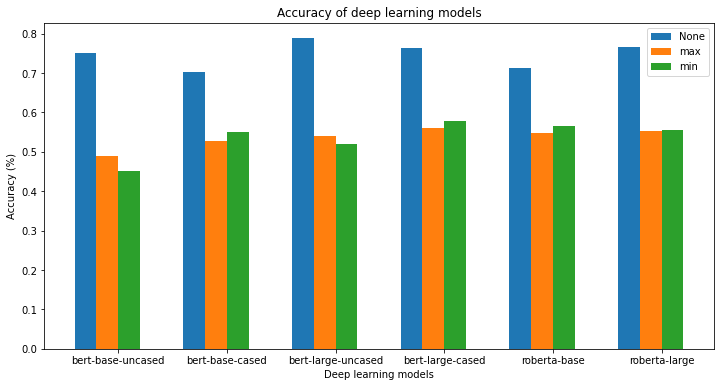

In [109]:
fig, ax = plt.subplots(figsize = (12, 6))
width = 0.1
for i, pm in zip(data, pooling_methods):
    ax.bar(np.arange(len(data[0]))+width, i, width = 0.2, label = pm)
    width +=0.2
plt.xticks(np.array(range(len(data[0])))+0.4, model_types)
plt.legend()
plt.xlabel("Deep learning models")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy of deep learning models")
plt.savefig(f"{rt_path}/deep.png")
plt.show()

In [115]:
DF['answer BERT'] = model_predictions[6]
DF['scores BERT'] = all_predictions[6]

DF['answer ROBERTA'] = model_predictions[15]
DF['scores ROBERTA'] = all_predictions[15]

# Model comparitive analysis

In [117]:
# storting all the data
df = DF

pred_uni = df['answer unigram']
pred_bi =  df['answer bigram']
pred_tri = df['answer trigram']

scores_uni = df['probs unigram']
scores_bi = df['probs bigram']
scores_tri = df['probs trigram']


pred_w2v = df['answer Word2Vec'] 
scores_w2v = df['scores Word2Vec']

pred_bert = df['answer BERT']
pred_roberta = df['answer ROBERTA']

scores_bert = df["scores BERT"]
scores_roberta = df['scores ROBERTA']

## Accuracy

In [118]:
# Function to get the accuracy

def get_accuracy(predicts):
    with open(answers_file) as instream:
        csvreader = csv.reader(instream)
        lines = list(csvreader)

    ans_df = pd.DataFrame(lines[1:], columns=lines[0])
    answers = np.array(ans_df['answer'])
    return np.sum(predicts == answers)/answers.shape[0]

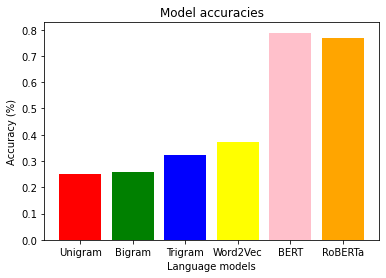

In [120]:
uni_acc = get_accuracy(pred_uni)
bi_acc = get_accuracy(pred_bi)
tri_acc = get_accuracy(pred_tri)
w2v_acc = get_accuracy(pred_w2v)
bert_acc = get_accuracy(pred_bert)
roberta_acc = get_accuracy(pred_roberta)

plt.bar(['Unigram', 'Bigram', 'Trigram', 'Word2Vec', 'BERT', "RoBERTa"], 
        [uni_acc, bi_acc, tri_acc, w2v_acc, bert_acc, roberta_acc], 
        color = ["red", "green", "blue", "yellow", "pink", "orange"])
plt.title('Model accuracies')
plt.xlabel('Language models')
plt.ylabel('Accuracy (%)')
plt.show()

## Answer analysis (error and correct answers)

In [121]:
# Function to compare the prediction between the answers

def prediction_comparision(pred1, pred2):
    with open(answers_file) as instream:
        csvreader = csv.reader(instream)
        lines = list(csvreader)
        
    ans_df = pd.DataFrame(lines[1:],columns=lines[0])
    answers = np.array(ans_df['answer'])

    overall = np.sum(np.array(pred1) == np.array(pred2)) / len(pred1) * 100

    right = np.sum(np.array([1 if answers[i] == pred1[i] and pred1[i] == pred2[i] else 0 for i in range(len(pred1))]))/len(pred1)*100
    wrong = np.sum(np.array([1 if answers[i] != pred1[i] and pred1[i] == pred2[i] else 0 for i in range(len(pred1))]))/len(pred1)*100

    return overall, right, wrong

In [129]:
# Defining all the model comaparisions

overall_uni_bi, right_uni_bi, wrong_uni_bi = prediction_comparision(pred_uni, pred_bi)
overall_uni_tri, right_uni_tri, wrong_uni_tri = prediction_comparision(pred_uni, pred_tri)
overall_uni_w2v, right_uni_w2v, wrong_uni_w2v = prediction_comparision(pred_uni, pred_w2v)
overall_uni_bert, right_uni_bert, wrong_uni_bert = prediction_comparision(pred_uni, pred_bert)
overall_uni_roberta, right_uni_roberta, wrong_uni_roberta = prediction_comparision(pred_uni, pred_roberta)

overall_bi_tri, right_bi_tri, wrong_bi_tri = prediction_comparision(pred_bi, pred_tri)
overall_bi_w2v, right_bi_w2v, wrong_bi_w2v = prediction_comparision(pred_bi, pred_w2v)
overall_bi_bert, right_bi_bert, wrong_bi_bert = prediction_comparision(pred_bi, pred_bert)
overall_bi_roberta, right_bi_roberta, wrong_bi_roberta = prediction_comparision(pred_bi, pred_roberta)

overall_tri_w2v, right_tri_w2v, wrong_tri_w2v = prediction_comparision(pred_tri, pred_w2v)
overall_tri_bert, right_tri_bert, wrong_tri_bert = prediction_comparision(pred_tri, pred_bert)
overall_tri_roberta, right_tri_roberta, wrong_tri_roberta = prediction_comparision(pred_tri, pred_roberta)

overall_w2v_bert, right_w2v_bert, wrong_w2v_bert = prediction_comparision(pred_w2v, pred_bert)
overall_w2v_roberta, right_w2v_roberta, wrong_w2v_roberta = prediction_comparision(pred_w2v, pred_roberta)

overall_bert_roberta, right_w2v_bert_roberta, wrong_w2v_bert_roberta = prediction_comparision(pred_bert, pred_roberta)

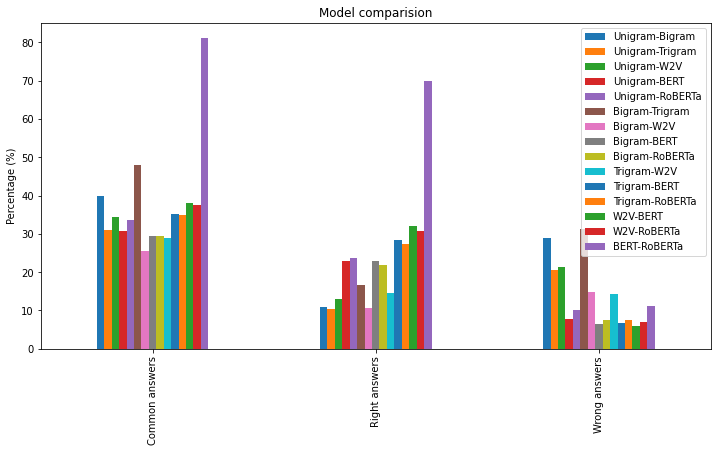

In [130]:
# Storing and plotting the common, right and wrong answers

xs = ['Common answers', 'Right answers', 'Wrong answers']
common = [overall_uni_bi, overall_uni_tri, overall_uni_w2v, overall_uni_bert, 
          overall_uni_roberta, overall_bi_tri, overall_bi_w2v, overall_bi_bert, 
          overall_bi_roberta, overall_tri_w2v, overall_tri_bert, overall_tri_roberta, 
          overall_w2v_bert, overall_w2v_roberta, overall_bert_roberta] 

right = [right_uni_bi, right_uni_tri, right_uni_w2v, right_uni_bert, 
         right_uni_roberta, right_bi_tri, right_bi_w2v, right_bi_bert, 
         right_bi_roberta, right_tri_w2v, right_tri_bert, right_tri_roberta, 
         right_w2v_bert, right_w2v_roberta, right_w2v_bert_roberta]

wrong = [wrong_uni_bi, wrong_uni_tri, wrong_uni_w2v, wrong_uni_bert, 
         wrong_uni_roberta, wrong_bi_tri, wrong_bi_w2v, wrong_bi_bert, 
         wrong_bi_roberta, wrong_tri_w2v, wrong_tri_bert, wrong_tri_roberta, 
         wrong_w2v_bert, wrong_w2v_roberta, wrong_w2v_bert_roberta]

labels = ['Unigram-Bigram', 'Unigram-Trigram', 'Unigram-W2V', 'Unigram-BERT', 'Unigram-RoBERTa',
          'Bigram-Trigram', "Bigram-W2V", "Bigram-BERT", "Bigram-RoBERTa", 
          "Trigram-W2V", "Trigram-BERT", "Trigram-RoBERTa",
          "W2V-BERT", "W2V-RoBERTa",
          "BERT-RoBERTa"]

df = pd.DataFrame((common, right, wrong), index=xs, columns=labels)
ax = df.plot(kind='bar', figsize=(12, 6))
ax.set_ylabel("Percentage (%)")
ax.set_title('Model comparision')
plt.show()

## Statistical error analysis

### Uncertainty

In [131]:
def error_analysis(pred, scores, flag):
    options_ = {"a" : 0, "b" : 1, "c" : 2, "d" : 3, "e" : 4}
    with open(answers_file) as instream:
        csvreader = csv.reader(instream)
        lines = list(csvreader)

    ans_df = pd.DataFrame(lines[1:],columns=lines[0])
    answers = np.array(ans_df['answer'])

    errors = []
    uncertainty = []
    for i in range(len(pred)):
        if answers[i] != pred[i]:
            errors.append(i)
            idx = options_[answers[i]]
            
            if flag:
                uncertainty.append(-math.log2(prob_normalization(scores[i])[idx]))
            else:
                uncertainty.append(-math.log2(cosine_normalization(scores[i])[idx]))
    return uncertainty, errors

In [132]:
def cosine_normalization(s):
    norm_s = np.array(s) + abs(min(s)) + 1
    return norm_s / np.sum(norm_s)

def prob_normalization(p):
    p_convert = 1 / sum(p)
    return [p_convert * _ for _ in p]

In [133]:
# Get uncertainties for the correct answer when an impostor has been chosen
uni_unc, uni_error = error_analysis(pred_uni, scores_uni, True)
bi_unc, bi_error = error_analysis(pred_bi, scores_bi, True)
tri_unc, tri_error = error_analysis(pred_tri, scores_tri, True)

w2v_unc, w2v_error = error_analysis(pred_w2v, scores_w2v, False)

bert_unc, bert_error = error_analysis(pred_bert, scores_bert, False)
roberta_unc, roberta_error = error_analysis(pred_roberta, scores_roberta, False)

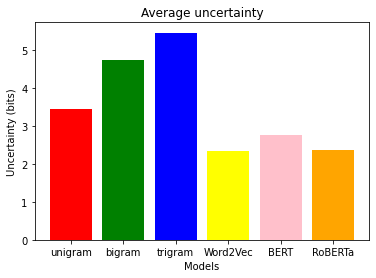

In [134]:
plt.bar(['unigram', 'bigram', 'trigram', 'Word2Vec', 'BERT', 'RoBERTa'], 
        [np.mean(uni_unc), np.mean(bi_unc), np.mean(tri_unc), np.mean(w2v_unc), 
         np.mean(bert_unc), np.mean(roberta_unc)], 
        color = ["red", "green", "blue", "yellow", "pink", "orange"])
plt.title('Average uncertainty')
plt.xlabel('Models')
plt.ylabel('Uncertainty (bits)')
plt.show()

### Entropy

In [140]:
entropy = lambda x : np.sum(-1*np.log2(x)*x)

In [141]:
print(f"Entropy baseline : {entropy([0.2 for i in range(5)])}")

Entropy baseline : 2.321928094887362


In [142]:
uni_ent = []
bi_ent = []
tri_ent = []
w2v_ent = []
bert_ent = []
roberta_ent = []

# getting the entroppy
for i in range(len(scores_uni)):
    uni_ent.append(entropy(prob_normalization(scores_uni[i])))
    bi_ent.append(entropy(prob_normalization(scores_bi[i])))
    tri_ent.append(entropy(prob_normalization(scores_tri[i])))
    w2v_ent.append(entropy(cosine_normalization(scores_w2v[i])))
    bert_ent.append(entropy(cosine_normalization(scores_bert[i])))
    roberta_ent.append(entropy(cosine_normalization(scores_roberta[i])))

# Average entropy
uni_ent = np.mean(uni_ent)
bi_ent = np.mean(bi_ent)
tri_ent = np.mean(tri_ent)
w2v_ent = np.mean(w2v_ent)
bert_ent = np.mean(bert_ent)
roberta_ent = np.mean(roberta_ent)

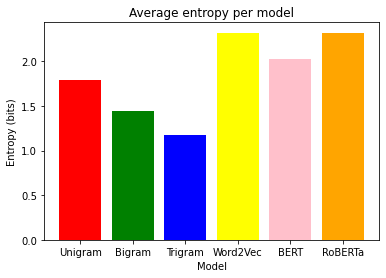

In [143]:
# plot for the respective model entropy

plt.bar(["Unigram", "Bigram", "Trigram", "Word2Vec", "BERT", "RoBERTa"], 
        [uni_ent, bi_ent, tri_ent, w2v_ent, bert_ent, roberta_ent], 
        color = ["red", "green", "blue", "yellow", "pink", "orange"])
plt.title('Average entropy per model')
plt.xlabel('Model')
plt.ylabel('Entropy (bits)')
plt.show()